<h1><div style="direction:ltr;font-family:B Lotus, B Nazanin, Tahoma">Cat_vs_dog_classifier_based on_data_gnerator</div></h1>

In [1]:
# importing required libraries and packages, which will be used through code.
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [2]:
# this part downloads the cat vs dog dataset from the google servers, and extracts them. finally, you will have train and validation data paths in two variables.
URL =     'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)

PATH =          os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir                    =  "/root/.keras/datasets/cats_and_dogs_filtered/train"
validation_dir           = "/root/.keras/datasets/cats_and_dogs_filtered/validation"

68616192/68606236 [==============================] - 1s 0us/step


In [3]:
print('total training images of cats:'  , len(os.listdir("/root/.keras/datasets/cats_and_dogs_filtered/train/cats"))     )
print('total training images of dogs:'  , len(os.listdir("/root/.keras/datasets/cats_and_dogs_filtered/train/dogs"))     )
print('total validation images of cats:', len(os.listdir("/root/.keras/datasets/cats_and_dogs_filtered/validation/cats")))
print('total validation images of dogs:', len(os.listdir("/root/.keras/datasets/cats_and_dogs_filtered/validation/cats")))

total training images of cats: 1000
total training images of dogs: 1000
total validation images of cats: 500
total validation images of dogs: 500


In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
datagen = ImageDataGenerator(
      rotation_range=45,
      width_shift_range =0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range =0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

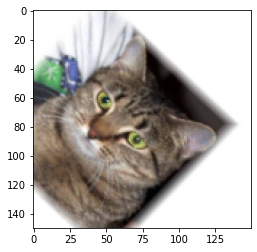

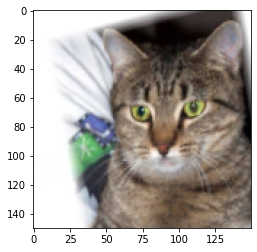

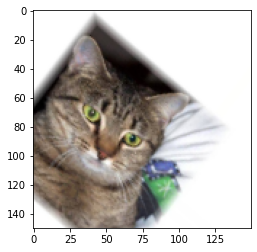

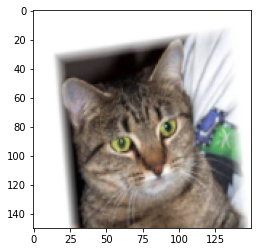

In [9]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join("/root/.keras/datasets/cats_and_dogs_filtered/train/cats", fname) for fname in os.listdir("/root/.keras/datasets/cats_and_dogs_filtered/train/cats")]

# We pick one image to "augment"
img_path = fnames[15]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting.

In [10]:
from keras import layers
from keras import models
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
train_datagen = ImageDataGenerator(
    rescale   =1./255,
    rotation_range=45,
    width_shift_range =0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range =0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 26s 261ms/step - loss: 0.6956 - acc: 0.5063 - val_loss: 0.6861 - val_acc: 0.6085
Epoch 2/100
100/100 [==============================] - 24s 240ms/step - loss: 0.6837 - acc: 0.5525 - val_loss: 0.6568 - val_acc: 0.6034
Epoch 3/100
100/100 [==============================] - 24s 242ms/step - loss: 0.6704 - acc: 0.5913 - val_loss: 0.6503 - val_acc: 0.6187
Epoch 4/100
100/100 [==============================] - 24s 241ms/step - loss: 0.6553 - acc: 0.6109 - val_loss: 0.6512 - val_acc: 0.6148
Epoch 5/100
100/100 [==============================] - 24s 237ms/step - loss: 0.6413 - acc: 0.6303 - val_loss: 0.6052 - val_acc: 0.6713
Epoch 6/100
100/100 [==============================] - 26s 256ms/step - loss: 0.6174 - acc: 0.6603 - val_loss: 0.6332 - val_acc: 0.6396
Epoch 7/100
100/100 [==============================] - 24s 238ms/step - loss: 0.6099 - acc: 0.6694 -

In [ ]:
model.save('cats_and_dogs_sample_model.h5')

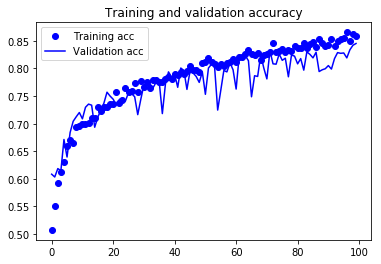

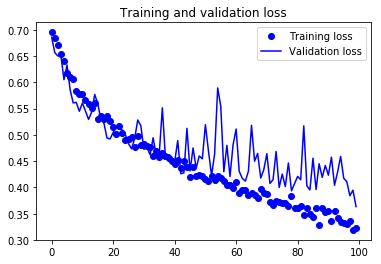

In [ ]:
acc  = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss= history.history['val_loss']

epochs  = range(len(acc))

plt.plot(epochs, acc, 'bo'     , label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title          ('Training and validation loss')
plt.legend()

plt.show()